In [1]:
%load_ext autoreload
%autoreload 2
from palm_tools import TrackSets
from palm_tools.analysis import MMDInterUnitAnalysis, MDSAnalysis, MMDInterGroupAnalysis
from palm_tools.post_processing import Gratin, GratinParameters
from palm_tools.post_processing.ts_post_processing import PostProcessingStepSeries
import pandas as pd
import numpy as np
from glob import glob
import os
import shutil
import zarr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if "Users" in os.getcwd():
    ORIGINAL_TRACKS_FILES = glob("/Users/hverdier/palm_tools_data/example_files/*.trxyt",recursive=True)
    EXPORT_FOLDER = "/Users/hverdier/palm_tools_data/export_folder"
else:
    # Source files, they're left untouched, only read
    ORIGINAL_TRACKS_FILES = glob("/home/hverdier/example_files/*.trxyt",recursive=True)
    # We copy files in this directory, it's as if they were 'uploaded' there by the user
    EXPORT_FOLDER = "/home/hverdier/export_folder"

if not os.path.exists(EXPORT_FOLDER):
    os.mkdir(EXPORT_FOLDER)
TRACKS_FILES = []
for f in ORIGINAL_TRACKS_FILES:
    tf = os.path.join(EXPORT_FOLDER,os.path.split(f)[-1])
    shutil.copy(f,tf)
    TRACKS_FILES.append(tf)

In [3]:
TRACKS_FILES

['/Users/hverdier/palm_tools_data/export_folder/66e67e9052c35e8d.trxyt',
 '/Users/hverdier/palm_tools_data/export_folder/1d372d16b9d77091.trxyt',
 '/Users/hverdier/palm_tools_data/export_folder/02e0de7a4caebc82.trxyt',
 '/Users/hverdier/palm_tools_data/export_folder/10fd51e9edc4d570.trxyt']

In [4]:
index_df = pd.DataFrame.from_dict({
    "file":TRACKS_FILES,
    "arbitrary_condition":[
        "A" if np.random.rand() > .5 else "B" for f in TRACKS_FILES
    ]})
index_df.head()

file arbitrary_condition
0  /Users/hverdier/palm_tools_data/export_folder/...                   A
1  /Users/hverdier/palm_tools_data/export_folder/...                   B
2  /Users/hverdier/palm_tools_data/export_folder/...                   A
3  /Users/hverdier/palm_tools_data/export_folder/...                   B

# Création du TrackSets

In [5]:
tss = TrackSets.from_files(TRACKS_FILES,root_folder=EXPORT_FOLDER,index_df=index_df)

In [6]:
for ts in tss:
    print(ts)

Set of 2529 trajs coming from file /Users/hverdier/palm_tools_data/export_folder/66e67e9052c35e8d.trxyt
Set of 1468 trajs coming from file /Users/hverdier/palm_tools_data/export_folder/1d372d16b9d77091.trxyt
Set of 693 trajs coming from file /Users/hverdier/palm_tools_data/export_folder/02e0de7a4caebc82.trxyt
Set of 595 trajs coming from file /Users/hverdier/palm_tools_data/export_folder/10fd51e9edc4d570.trxyt


In [7]:
tss[0].locs.head()

Unnamed: 0         x         y   n  frame   t
35          35  6.493394  6.674981  56     10  10
41          41  6.494026  6.812881  56     11  11
45          45  6.461595  6.709958  56     12  12
49          49  6.494565  6.672934  56     13  13
52          52  6.515212  6.698189  56     14  14

# Embeddings avec Gratin

In [8]:
gratin_path = "/Users/hverdier/models/demo"
#Gratin.train_model(export_path=gratin_path,time_delta=0.03)

In [9]:
gt = Gratin(params=GratinParameters(path=gratin_path))

In [10]:
pps = PostProcessingStepSeries(processing_steps=[gt])

In [11]:
pps.process(tss)

Processing in PPSS :   0%|          | 0/4 [00:00<?, ?it/s, /Users/hverdier/palm_tools_data/export_folder/66e67e9052c35e8d.trxyt : Gratin latent vectors and output]2022-04-29 16:55:50.963989: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Processing in PPSS : 100%|██████████| 4/4 [00:19<00:00,  4.98s/it, /Users/hverdier/palm_tools_data/export_folder/10fd51e9edc4d570.trxyt : Gratin latent vectors and output]


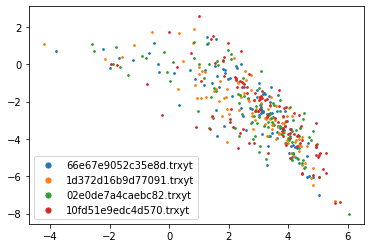

In [12]:
# Visualize latent vectors
for ts in tss:
    U = ts.locs.groupby("n")[["U_1","U_2"]].mean().sample(100).values
    plt.scatter(U[:,0],U[:,1],label=os.path.split(ts.origin_file)[1],s=3)
plt.legend(markerscale=3)

# MMD inter units

In [13]:
RUN_NAME = "example"

mmd = MMDInterUnitAnalysis(track_sets=tss,
    unit_key=["file"], 
    # it is possible to delimit units by a column of the trajectories files (if they have additional information)
    # or to consider a cartesian product of two columns. 
    # example of valid values : ["file","time_bin"], ["file","organelle"], ["organelle"] (spanned across files)
    use_high_dimension=False,
    n_bootstraps=250,
    n_max_trajs_per_unit=500, # For speed, we never consider more than 500 trajectories per unit
    n_min_trajs_per_unit=150, # For accuracy, we discard units with less than 150 trajectories
    run_name=RUN_NAME)

In [14]:
mmd.process()

In [15]:
# Dossier où sont stockés les résultats
# tss.root_folder / MMD_inter_groups / mmd.run_name 
print(mmd.output_path)

/Users/hverdier/palm_tools_data/export_folder/MMD_inter_units/example


In [16]:
# fichiers exportés :
glob(os.path.join(mmd.output_path,"*"))

['/Users/hverdier/palm_tools_data/export_folder/MMD_inter_units/example/p_value.zip',
 '/Users/hverdier/palm_tools_data/export_folder/MMD_inter_units/example/D_bootstrap.zip',
 '/Users/hverdier/palm_tools_data/export_folder/MMD_inter_units/example/units.json',
 '/Users/hverdier/palm_tools_data/export_folder/MMD_inter_units/example/latent_df.csv',
 '/Users/hverdier/palm_tools_data/export_folder/MMD_inter_units/example/D_true.zip']

In [17]:
# Il faut regarder les fonctions "_load()" des différentes classes d'analyses pour voir comment lire les fichiers qu'elles exportent
# par ex :
mmd._p_value

array([[0.        , 0.00227647, 0.00164032, 0.00287952],
       [0.00227647, 0.        , 0.00128539, 0.00290616],
       [0.00164032, 0.00128539, 0.        , 0.00062272],
       [0.00287952, 0.00290616, 0.00062272, 0.        ]])

In [18]:
zarr.load("/Users/hverdier/palm_tools_data/export_folder/MMD_inter_units/example/p_value.zip")

array([[0.        , 0.00227647, 0.00164032, 0.00287952],
       [0.00227647, 0.        , 0.00128539, 0.00290616],
       [0.00164032, 0.00128539, 0.        , 0.00062272],
       [0.00287952, 0.00290616, 0.00062272, 0.        ]])

In [19]:
# -> OK, les p-values ont bien été stockées et on peut les lire

In [20]:
mmd.latent_df

n        U_1        U_2  \
0        63   8.323156  -9.620292   
1        72  10.887812  -6.418210   
2       144  13.987446  -7.992294   
3       211   8.541023  -7.866675   
4       273  -0.889406 -14.018053   
...     ...        ...        ...   
5280  83099   3.411191  -8.746538   
5281  83155   9.590019  -0.655477   
5282  83177  -0.442788 -10.830650   
5283  83238   2.644638 -10.250572   
5284  83291   3.364262  -7.645683   

                                                   file arbitrary_condition  \
0     /Users/hverdier/palm_tools_data/export_folder/...                   A   
1     /Users/hverdier/palm_tools_data/export_folder/...                   A   
2     /Users/hverdier/palm_tools_data/export_folder/...                   A   
3     /Users/hverdier/palm_tools_data/export_folder/...                   A   
4     /Users/hverdier/palm_tools_data/export_folder/...                   A   
...                                                 ...                 ...   
5280  /Users/hverdier/palm_tools_data/export_folder/...                   B   
5281  /Users/hverdier/palm_tools_data/export_folder/...                   B   
5282  /Users/hverdier/palm_tools_data/export_folder/...                   B   
5283  /Users/hverdier/palm_tools_data/export_folder/...                   B   
5284  /Users/hverdier/palm_tools_data/export_folder/...                   B   

      unit  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
5280     3  
5281     3  
5282     3  
5283     3  
5284     3  

[5285 rows x 6 columns]

In [21]:
pd.read_csv("/Users/hverdier/palm_tools_data/export_folder/MMD_inter_units/example/latent_df.csv")

n        U_1        U_2  \
0        63   8.323156  -9.620292   
1        72  10.887812  -6.418210   
2       144  13.987446  -7.992294   
3       211   8.541023  -7.866675   
4       273  -0.889406 -14.018053   
...     ...        ...        ...   
5280  83099   3.411191  -8.746538   
5281  83155   9.590019  -0.655477   
5282  83177  -0.442788 -10.830650   
5283  83238   2.644638 -10.250572   
5284  83291   3.364262  -7.645683   

                                                   file arbitrary_condition  \
0     /Users/hverdier/palm_tools_data/export_folder/...                   A   
1     /Users/hverdier/palm_tools_data/export_folder/...                   A   
2     /Users/hverdier/palm_tools_data/export_folder/...                   A   
3     /Users/hverdier/palm_tools_data/export_folder/...                   A   
4     /Users/hverdier/palm_tools_data/export_folder/...                   A   
...                                                 ...                 ...   
5280  /Users/hverdier/palm_tools_data/export_folder/...                   B   
5281  /Users/hverdier/palm_tools_data/export_folder/...                   B   
5282  /Users/hverdier/palm_tools_data/export_folder/...                   B   
5283  /Users/hverdier/palm_tools_data/export_folder/...                   B   
5284  /Users/hverdier/palm_tools_data/export_folder/...                   B   

      unit  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
5280     3  
5281     3  
5282     3  
5283     3  
5284     3  

[5285 rows x 6 columns]

In [22]:
# -> C'est OK avec les vecteurs latents aussi

# MDS based on it

In [23]:
mds = MDSAnalysis(track_sets=tss,mmd=mmd,run_name=RUN_NAME)

In [24]:
mds.process()

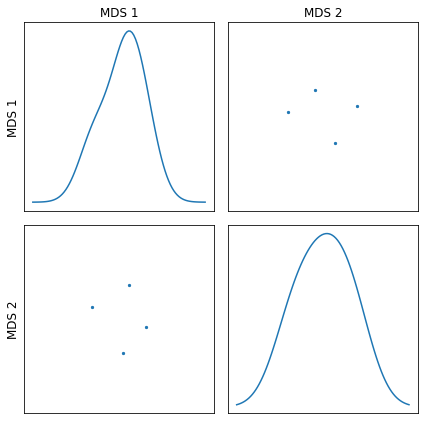

In [25]:
mds.plot_scatter()

In [26]:
# Idem, le dossier suit la même logique
print(mds.output_path)
print(glob(os.path.join(mds.output_path,"*")))

/Users/hverdier/palm_tools_data/export_folder/MDS/example
['/Users/hverdier/palm_tools_data/export_folder/MDS/example/unit_info.csv']


In [27]:
mds.unit_info

file  unit  \
0  /Users/hverdier/palm_tools_data/export_folder/...     0   
1  /Users/hverdier/palm_tools_data/export_folder/...     1   
2  /Users/hverdier/palm_tools_data/export_folder/...     2   
3  /Users/hverdier/palm_tools_data/export_folder/...     3   

  arbitrary_condition       X_1       X_2  
0                   A  0.010200  0.021437  
1                   A -0.017200  0.002806  
2                   B  0.022468 -0.013975  
3                   B  0.005833 -0.035697

In [28]:
pd.read_csv("/Users/hverdier/palm_tools_data/export_folder/MDS/example/unit_info.csv",index_col=0)

file  unit  \
0  /Users/hverdier/palm_tools_data/export_folder/...     0   
1  /Users/hverdier/palm_tools_data/export_folder/...     1   
2  /Users/hverdier/palm_tools_data/export_folder/...     2   
3  /Users/hverdier/palm_tools_data/export_folder/...     3   

  arbitrary_condition       X_1       X_2  
0                   A  0.010200  0.021437  
1                   A -0.017200  0.002806  
2                   B  0.022468 -0.013975  
3                   B  0.005833 -0.035697

# MMD inter groups

In [29]:
mmd = MMDInterGroupAnalysis(track_sets=tss,
    unit_key=["file"],
    null_mode="mix",
    group_by_keys=["arbitrary_condition"],
    # it is possible to delimit units by a column of the trajectories files (if they have additional information)
    # or to consider a cartesian product of two columns. 
    # example of valid values : ["file","time_bin"], ["file","organelle"], ["organelle"] (spanned across files)
    use_high_dimension=False,
    n_max_bootstraps=250,
    n_max_trajs_per_unit=500, # For speed, we never consider more than 500 trajectories per unit
    n_min_trajs_per_unit=150, # For accuracy, we discard units with less than 150 trajectories
    run_name=RUN_NAME)

In [30]:
mmd.process(force_recompute=True)

Adding units from tracksets: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it, 2529 trajs from /Users/hverdier/palm_tools_data/export_folder/66e67e9052c35e8d.trxyt]


latent_df has 4 units


  0%|          | 0/1 [00:00<?, ?it/s]

# units 
	 A : 2
	 B : 2
min_n = 595 (693, 595)
# of trajs : 1000 vs 1000


(250 bootstraps) : {'arbitrary_condition': 'A'} VS {'arbitrary_condition': 'B'}: 100%|██████████| 1/1 [00:23<00:00, 23.46s/it]


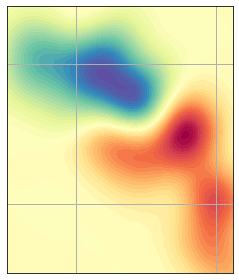

In [31]:
mmd.plot_witness_function({"arbitrary_condition":"A"},{"arbitrary_condition":"B"})

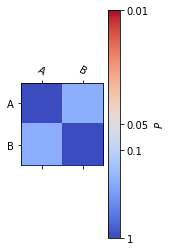

In [32]:
mmd.plot_mosaic()

/Users/hverdier/palm-tools/src/palm_tools/analysis/mmd_analysis.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values("distance", inplace=True)
/Users/hverdier/palm-tools/src/palm_tools/analysis/mmd_analysis.py:867: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


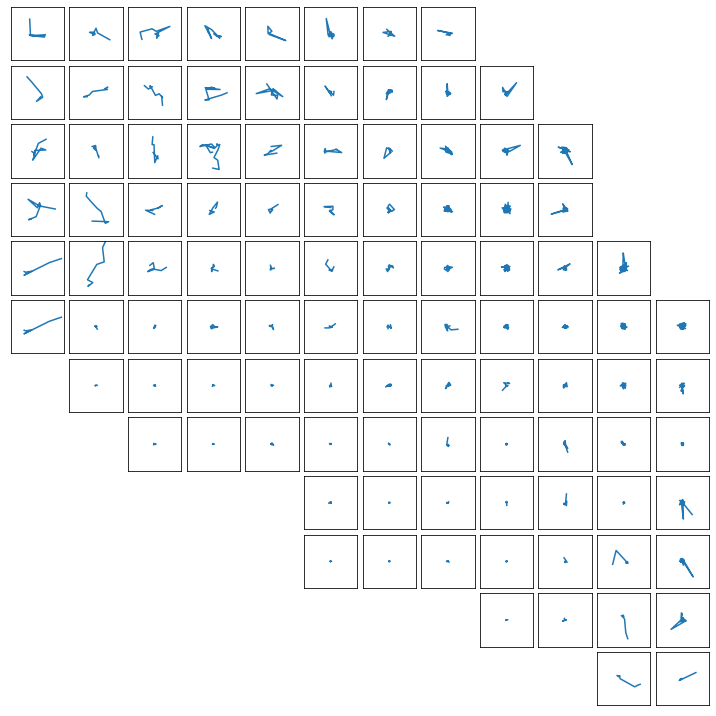

In [33]:
mmd.plot_latent_map()

/Users/hverdier/palm-tools/src/palm_tools/analysis/mmd_analysis.py:1019: RuntimeWarning: invalid value encountered in true_divide
  stat = N * amplitude / var


Interpolations are done
Looking at critical trajectories


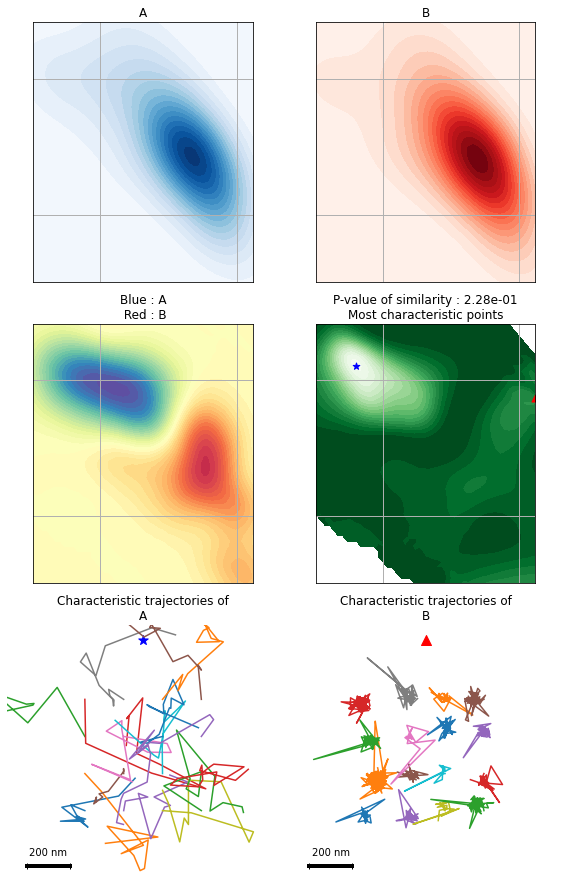

In [34]:
mmd.plot_discriminant_trajs({"arbitrary_condition":"A"},{"arbitrary_condition":"B"})